In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch
from torch import nn
from torch.optim import Adam
from torch.utils.data import TensorDataset, DataLoader

import os
from tqdm import tqdm
tqdm.pandas()
from collections import Counter

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
%cd /content/drive/MyDrive/

/content/drive/MyDrive


In [4]:
data = pd.read_csv('exercise4.csv')
data.head()

,processed,label
0,One reviewer mentioned watching Oz episode hoo...,1
1,A wonderful little production . The filming te...,1
2,I thought wonderful way spend time hot summer ...,1
3,Basically family little boy Jake think zombie ...,0
4,Petter Mattei Love Time Money visually stunnin...,1


In [5]:
data['processed'] = data['processed'].str.lower().replace(r"[^a-zA-Z ]", "", regex=True)

In [6]:
data['processed'][0]

'one reviewer mentioned watching oz episode hooked  they right  exactly happened  the first thing struck oz brutality unflinching scene violence  set right word go  trust  show faint hearted timid  this show pull punch regard drug  sex violence  its hardcore  classic use word  it called oz nickname given oswald maximum security state penitentary  it focus mainly emerald city  experimental section prison cell glass front face inwards  privacy high agenda  em city home many   aryans  muslims  gangsta  latinos  christians  italians  irish     scuffle  death stare  dodgy dealing shady agreement never far away  i would say main appeal show due fact go show dare  forget pretty picture painted mainstream audience  forget charm  forget romance    oz mess around  the first episode i ever saw struck nasty surreal  i say i ready  i watched  i developed taste oz  got accustomed high level graphic violence  not violence  injustice crooked guard sold nickel  inmate kill order get away  well mannered

In [7]:
# 문장에 포함된 단어 토큰화
reviews = data['processed'].values
words = ' '.join(reviews).split()
words[:10]

['one',
 'reviewer',
 'mentioned',
 'watching',
 'oz',
 'episode',
 'hooked',
 'they',
 'right',
 'exactly']

In [8]:
counter = Counter(words)
vocab = sorted(counter, key=counter.get, reverse=True)
int2word = dict(enumerate(vocab, 1))
int2word[0] = '<PAD>'
word2int = {word: id for id, word in int2word.items()}
word2int

{'i': 1,
 'movie': 2,
 'film': 3,
 'the': 4,
 'one': 5,
 'like': 6,
 'it': 7,
 'time': 8,
 'this': 9,
 'good': 10,
 'character': 11,
 'story': 12,
 'even': 13,
 'get': 14,
 'would': 15,
 'make': 16,
 'see': 17,
 'really': 18,
 'scene': 19,
 'well': 20,
 'much': 21,
 'bad': 22,
 'people': 23,
 'great': 24,
 'also': 25,
 'first': 26,
 'show': 27,
 'way': 28,
 'made': 29,
 'thing': 30,
 'could': 31,
 'life': 32,
 'think': 33,
 'go': 34,
 'but': 35,
 'know': 36,
 'watch': 37,
 'and': 38,
 'love': 39,
 'plot': 40,
 'two': 41,
 'actor': 42,
 'many': 43,
 'seen': 44,
 'a': 45,
 'say': 46,
 'year': 47,
 'never': 48,
 'end': 49,
 'acting': 50,
 'look': 51,
 'best': 52,
 'little': 53,
 'in': 54,
 'there': 55,
 'ever': 56,
 'man': 57,
 'better': 58,
 'take': 59,
 'if': 60,
 'come': 61,
 'work': 62,
 'still': 63,
 'he': 64,
 'part': 65,
 'something': 66,
 'find': 67,
 'director': 68,
 'want': 69,
 'back': 70,
 'give': 71,
 'lot': 72,
 'real': 73,
 'watching': 74,
 'guy': 75,
 'performance': 76,
 '

In [9]:
reviews_enc = [[word2int[word] for word in review.split()] for review in tqdm(reviews)]

100%|██████████| 50000/50000 [00:02<00:00, 23612.79it/s]


In [10]:
reviews_enc[0][:10]

[5, 1095, 972, 74, 2893, 186, 2982, 119, 114, 538]

In [11]:
data['processed'][0]

'one reviewer mentioned watching oz episode hooked  they right  exactly happened  the first thing struck oz brutality unflinching scene violence  set right word go  trust  show faint hearted timid  this show pull punch regard drug  sex violence  its hardcore  classic use word  it called oz nickname given oswald maximum security state penitentary  it focus mainly emerald city  experimental section prison cell glass front face inwards  privacy high agenda  em city home many   aryans  muslims  gangsta  latinos  christians  italians  irish     scuffle  death stare  dodgy dealing shady agreement never far away  i would say main appeal show due fact go show dare  forget pretty picture painted mainstream audience  forget charm  forget romance    oz mess around  the first episode i ever saw struck nasty surreal  i say i ready  i watched  i developed taste oz  got accustomed high level graphic violence  not violence  injustice crooked guard sold nickel  inmate kill order get away  well mannered

In [12]:
word2int['one'], word2int['reviewer'], word2int['mentioned']

(5, 1095, 972)

In [13]:
data['encoded'] = reviews_enc

In [14]:
def pad_features(reviews, pad_id, seq_length=128):
    features = np.full((len(reviews), seq_length), pad_id, dtype=int)  # np.full((5, 3), 2)

    for i, row in enumerate(reviews):
        # if seq_length < len(row) then review will be trimmed
        features[i, :len(row)] = np.array(row)[:seq_length]

    return features

seq_length = 256
features = pad_features(reviews_enc, pad_id=word2int['<PAD>'], seq_length=seq_length)

assert len(features) == len(reviews_enc)
assert len(features[0]) == seq_length

In [15]:
labels = data['label'].to_numpy()
labels

array([1, 1, 1, ..., 0, 0, 0])

In [16]:
# train test split
train_size = .8
split_id = int(len(features) * train_size)
train_x, test_x, train_y, test_y = features[:split_id], features[split_id:], labels[:split_id], labels[split_id:]

split_id = int(len(train_x) * train_size)
train_x, valid_x, train_y, valid_y = train_x[:split_id], train_x[split_id:], train_y[:split_id], train_y[split_id:]
print('Train shape:{}, Valid shape: {}, Test shape: {}'.format(train_x.shape, valid_x.shape, test_x.shape))
print('Train shape:{}, Valid shape: {}, Test shape: {}'.format(train_y.shape, valid_y.shape, test_y.shape))

Train shape:(32000, 256), Valid shape: (8000, 256), Test shape: (10000, 256)
Train shape:(32000,), Valid shape: (8000,), Test shape: (10000,)


In [17]:
# set hyperparameter
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

lr = 0.001
batch_size = 128
vocab_size = len(word2int)
embedding_size = 256
dropout=0.25

epochs = 8
history = {
    'train_loss': [],
    'train_acc': [],
    'val_loss': [],
    'val_acc': [],
    'epochs': epochs
}
es_limit = 5

cuda


In [18]:
trainset = TensorDataset(torch.from_numpy(train_x), torch.from_numpy(train_y))
validset = TensorDataset(torch.from_numpy(valid_x), torch.from_numpy(valid_y))
testset = TensorDataset(torch.from_numpy(test_x), torch.from_numpy(test_y))

trainloader = DataLoader(trainset, shuffle=True, batch_size=batch_size)
valloader = DataLoader(validset, shuffle=True, batch_size=batch_size)
testloader = DataLoader(testset, shuffle=True, batch_size=batch_size)

In [19]:
class LSTMClassifier(nn.Module):
    def __init__(self, vocab_size, embedding_size=400):
        super(LSTMClassifier, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_size)
        self.lstm = nn.LSTM(embedding_size, 512, 2, dropout=0.25, batch_first=True)
        self.dropout = nn.Dropout(0.3)
        self.fc = nn.Linear(512, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = x.long()
        x = self.embedding(x)
        o, _ =  self.lstm(x)
        o = o[:, -1, :]
        o = self.dropout(o)
        o = self.fc(o)
        o = self.sigmoid(o)

        return o

In [20]:
model = LSTMClassifier(vocab_size, embedding_size).to(device)
print(model)

LSTMClassifier(
  (embedding): Embedding(96140, 256)
  (lstm): LSTM(256, 512, num_layers=2, batch_first=True, dropout=0.25)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=512, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


In [21]:
criterion = nn.BCELoss()
optim = Adam(model.parameters(), lr=lr)

In [22]:
def train(model, trainloader):
    model.train()

    train_loss = 0
    train_acc = 0

    for id, (X, y) in enumerate(trainloader):
        X, y = X.to(device), y.to(device)        
        optim.zero_grad()
        y_pred = model(X)
        loss = criterion(y_pred.squeeze(), y.float())
        loss.backward()
        optim.step()

        train_loss += loss.item()
        y_pred = torch.tensor([1 if i == True else 0 for i in y_pred > 0.5], device=device)
        equals = y_pred == y
        acc = torch.mean(equals.type(torch.FloatTensor))
        train_acc += acc.item()

    history['train_loss'].append(train_loss / len(trainloader))
    history['train_acc'].append(train_acc / len(trainloader))

    return train_loss, train_acc

In [23]:
def validation(model, valloader):
    model.eval()

    val_loss = 0
    val_acc = 0

    with torch.no_grad():
        for id, (X, y) in enumerate(valloader):            
            X, y = X.to(device), y.to(device)
            y_pred = model(X)
            loss = criterion(y_pred.squeeze(), y.float())
            
            val_loss += loss.item()
            
            y_pred = torch.tensor([1 if i == True else 0 for i in y_pred > 0.5], device=device)
            equals = y_pred == y
            acc = torch.mean(equals.type(torch.FloatTensor))
            val_acc += acc.item()

        history['val_loss'].append(val_loss / len(valloader))
        history['val_acc'].append(val_acc / len(valloader))

    return val_loss, val_acc

In [24]:
# train loop
epochloop = tqdm(range(epochs), desc='Training')

# early stop trigger
es_trigger = 0
val_loss_min = torch.inf

for e in epochloop:
    train_loss, train_acc = train(model, trainloader)
    val_loss, val_acc = validation(model, valloader)
    epochloop.write(f'Epoch[{e+1}/{epochs}] Train Loss: {train_loss / len(trainloader):.3f}, Train Acc: {train_acc / len(trainloader):.3f}, Val Loss: {val_loss / len(valloader):.3f}, Val Acc: {val_acc / len(valloader):.3f}')

    # save model if validation loss decrease
    if val_loss / len(valloader) <= val_loss_min:
        torch.save(model.state_dict(), './sentiment_lstm.pt')
        val_loss_min = val_loss / len(valloader)
        es_trigger = 0
    else:       
        es_trigger += 1

    # early stop
    if es_trigger >= es_limit:
        epochloop.write(f'Early stopped at Epoch-{e+1}')
        history['epochs'] = e+1
        break

Training:   0%|          | 0/8 [01:04<?, ?it/s]

Epoch[1/8] Train Loss: 0.694, Train Acc: 0.509, Val Loss: 0.695, Val Acc: 0.487


Training:  12%|█▎        | 1/8 [02:16<07:33, 64.82s/it]

Epoch[2/8] Train Loss: 0.694, Train Acc: 0.504, Val Loss: 0.693, Val Acc: 0.512


Training:  25%|██▌       | 2/8 [03:27<06:53, 68.86s/it]

Epoch[3/8] Train Loss: 0.688, Train Acc: 0.514, Val Loss: 0.693, Val Acc: 0.516


Training:  50%|█████     | 4/8 [04:38<04:41, 70.31s/it]

Epoch[4/8] Train Loss: 0.667, Train Acc: 0.531, Val Loss: 0.704, Val Acc: 0.516


Training:  50%|█████     | 4/8 [05:49<04:41, 70.31s/it]

Epoch[5/8] Train Loss: 0.517, Train Acc: 0.749, Val Loss: 0.480, Val Acc: 0.799


Training:  62%|██████▎   | 5/8 [07:01<03:32, 70.78s/it]

Epoch[6/8] Train Loss: 0.327, Train Acc: 0.867, Val Loss: 0.418, Val Acc: 0.837


Training:  88%|████████▊ | 7/8 [08:13<01:11, 71.11s/it]

Epoch[7/8] Train Loss: 0.216, Train Acc: 0.921, Val Loss: 0.422, Val Acc: 0.847


Training: 100%|██████████| 8/8 [09:24<00:00, 70.53s/it]

Epoch[8/8] Train Loss: 0.132, Train Acc: 0.957, Val Loss: 0.486, Val Acc: 0.841


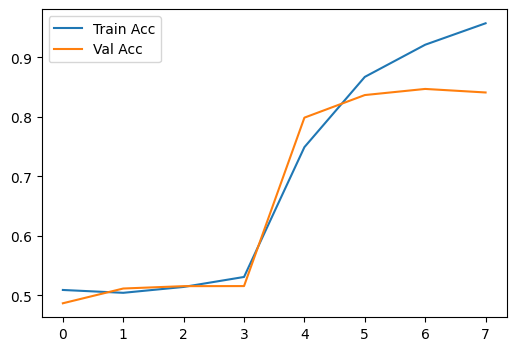

In [25]:
# plot loss
plt.figure(figsize=(6, 4))
plt.plot(range(history['epochs']), history['train_acc'], label='Train Acc')
plt.plot(range(history['epochs']), history['val_acc'], label='Val Acc')
plt.legend()
plt.show()

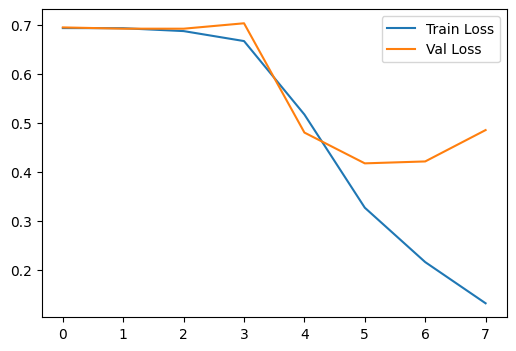

In [26]:
plt.figure(figsize=(6, 4))
plt.plot(range(history['epochs']), history['train_loss'], label='Train Loss')
plt.plot(range(history['epochs']), history['val_loss'], label='Val Loss')
plt.legend()
plt.show()